In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, classification_report, f1_score
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.preprocessing import LabelEncoder
from category_encoders import TargetEncoder


from sklearn.ensemble import RandomForestClassifier

In [2]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [3]:
class CustomLabelEncoder(LabelEncoder):
    def __init__(self, unknown_value=-1):
        super().__init__()
        self.unknown_value = unknown_value
    def fit(self, y):
        super().fit(y)
        return self
    def transform(self, y):
        labels = np.array([self.unknown_value] * len(y))
        mask = np.isin(y, self.classes_)
        labels[mask] = super().transform(y[mask])
        return labels
    def fit_transform(self, y):
        return self.fit(y).transform(y)

# Combine all unique values from Target_Status, Drug_high_status, and Drug_Status
all_status_values = set(df_train['Target_Status'].unique())
all_status_values.update(df_train['Drug_high_status'].unique())
all_status_values.update(df_train['Drug_Status'].unique())
all_status_values.update(df_test['Drug_high_status'].unique())
all_status_values.update(df_test['Drug_Status'].unique())

# Create and fit the CustomLabelEncoder with all unique status values
le = CustomLabelEncoder()
le.fit(list(all_status_values))

# Print the mapping between original values and their encodings
print("Mapping of original values to encoded values:")
for original_value, encoded_value in zip(le.classes_, le.transform(le.classes_)):
    print(f"Original: {original_value}, Encoded: {encoded_value}")

# Encode Target_Status, Drug_high_status, and Drug_Status
status_columns = ['Target_Status', 'Drug_high_status', 'Drug_Status']
for col in status_columns:
    if col in df_train.columns:
        df_train[col] = le.transform(df_train[col])
    if col in df_test.columns:
        df_test[col] = le.transform(df_test[col])

# Rest of the code remains the same...

# Perform Target Encoding on the specified columns
columns_to_encode = [
    "DRUGTYPE", "DRUGNAME", "Disease_of_highest_status", "UNIPROID", 
    "TARGNAME", "GENENAME", "FUNCTION", "BIOCLASS", "SEQUENCE", 
    "Disease", "Accession Number", "TargetID", "DRUGID"
]

# Initialize the TargetEncoder
te = TargetEncoder()

# Fit and transform the training data
df_train_encoded = te.fit_transform(df_train[columns_to_encode], df_train['Target_Status'])

# Transform the test data
df_test_encoded = te.transform(df_test[columns_to_encode])

# Combine the encoded columns with the original dataframes
df_train_final = pd.concat([df_train.drop(columns=columns_to_encode), df_train_encoded], axis=1)
df_test_final = pd.concat([df_test.drop(columns=columns_to_encode), df_test_encoded], axis=1)

# Print the first few rows of the encoded dataframes
print("\nFirst few rows of df_train_final:")
print(df_train_final.head())

print("\nFirst few rows of df_test_final:")
print(df_test_final.head())

Mapping of original values to encoded values:
Original: Application submitted, Encoded: 0
Original: Approved, Encoded: 1
Original: Approved (orphan drug), Encoded: 2
Original: BLA submitted, Encoded: 3
Original: Clinical trial, Encoded: 4
Original: Discontinued in Phase 1, Encoded: 5
Original: Discontinued in Phase 1/2, Encoded: 6
Original: Discontinued in Phase 2, Encoded: 7
Original: Discontinued in Phase 2/3, Encoded: 8
Original: Discontinued in Phase 2a, Encoded: 9
Original: Discontinued in Phase 2b, Encoded: 10
Original: Discontinued in Phase 3, Encoded: 11
Original: Discontinued in Phase 4, Encoded: 12
Original: Discontinued in Preregistration, Encoded: 13
Original: IND submitted, Encoded: 14
Original: Investigative, Encoded: 15
Original: NDA filed, Encoded: 16
Original: Patented, Encoded: 17
Original: Phase 0, Encoded: 18
Original: Phase 1, Encoded: 19
Original: Phase 1 Trial, Encoded: 20
Original: Phase 1/2, Encoded: 21
Original: Phase 1/2a, Encoded: 22
Original: Phase 1b, Enco

In [4]:
df_train_final.head(10)

ID  Drug_high_status  PUBCHCID  Drug_Status  \
0  140736                 1    154059            1   
1  133048                15  46843035           15   
2   60493                19  24767976           19   
3  169176                11    176408           11   
4  120183                 1      3290            1   
5  137655                 1  56649450           25   
6   86935                 1  25141092           25   
7   96089                 1       938            1   
8  142033                30  11658655           25   
9   25065                25    132787           25   

                                            SYNONYMS  Target_Status  \
0  Voltage-gated calcium channel subunit alpha Ca...             35   
1  Prostaglandin-endoperoxide synthase 1; Prostag...              1   
2  VEGFR2; VEGFR-2; VEGF-2 receptor; Protein-tyro...              1   
3     Adenosine receptor A1; A(1) adenosine receptor             25   
4                                 YT; N-ACHE; ARACHE              1   
5  Target of rapamycin; TOR kinase; Rapamycin tar...             21   
6                           IR; CD220 antigen; CD220              1   
7     Xanthine oxidase; Xanthine dehydrogenase; XDHA             25   
8  Solute carrier family 6 member 2; Sodium-depen...              1   
9  Serotonin receptor 1A; G-21; ADRBRL1; ADRB2RL1...             30   

    DRUGTYPE   DRUGNAME  Disease_of_highest_status   UNIPROID   TARGNAME  \
0  17.386316  10.227211                  10.819407  30.083333  30.083333   
1  17.386316  16.783376                  18.498496  14.959757  14.959757   
2  17.386316  19.118938                  19.007978  16.870866  16.870866   
3  17.386316  19.343167                  16.172712  17.197802  17.197802   
4  17.386316  15.798900                  15.784146  11.386805  11.386805   
5  17.386316  19.192857                  19.007978  17.288815  17.288815   
6  17.386316  18.976465                  19.007978  18.632231  18.632231   
7  17.386316  18.026669                  20.241263  19.900552  19.900552   
8  17.386316  14.091509                  17.388122  12.473313  12.473313   
9  17.386316  19.134973                  16.542443  20.139152  20.139152   

    GENENAME   FUNCTION   BIOCLASS   SEQUENCE    Disease  Accession Number  \
0  30.083333  30.083333  18.064134  30.083333  24.890909         30.083333   
1  14.959757  14.959757  16.855244  13.695343  19.076882         14.959757   
2  16.870866  16.870866  19.144389  16.870866  12.515116         16.870866   
3  17.197802  17.197802  16.222578  17.197802  16.119205         17.197802   
4  11.386805  11.386805  11.672689  11.386805   1.121170         11.386805   
5  17.288815  17.288815  19.144389  17.288815  20.576310         17.288815   
6  18.632231  18.632231  19.144389  18.632231  17.320489         18.632231   
7  19.900552  19.900552  19.853261  19.900552  25.281010         19.900552   
8  12.473313  12.473313  14.918772  12.473313  14.606250         12.473313   
9  20.139152  20.139152  16.222578  20.139152  14.539841         20.139152   

    TargetID     DRUGID  
0  30.083333  10.227211  
1  14.959757  16.783376  
2  16.870866  19.118938  
3  17.197802  19.343167  
4  11.386805  15.798900  
5  17.288815  19.192857  
6  18.632231  18.976465  
7  19.900552  18.026669  
8  12.473313  14.091509  
9  20.139152  19.134973

In [5]:
df_test_final.head()

ID  Drug_high_status  PUBCHCID  Drug_Status  \
0    1076                25  23581869           25   
1  190816                15  16742063           15   
2  180551                 1   5329102            1   
3   51630                 1      4927            1   
4   50566                 1      5002           30   

                                            SYNONYMS   DRUGTYPE   DRUGNAME  \
0  Gamma-aminobutyric acid receptor subunit alpha...  17.386316  14.731578   
1  Stem cell tyrosine kinase 1; STK1; STK-1; Rece...  17.386316  17.634246   
2  Tyrosine-protein kinase Met; Scatter factor re...  17.386316  19.079090   
3        Dopamine receptor 2; D(2) dopamine receptor  17.386316  13.560156   
4        Dopamine receptor 2; D(2) dopamine receptor  17.386316  14.960171   

   Disease_of_highest_status   UNIPROID   TARGNAME   GENENAME   FUNCTION  \
0                  16.542443   6.988638   6.988638   6.988638   6.988638   
1                  17.634246  17.619192  17.619192  17.619192  17.619192   
2                  19.093496  21.639640  21.639640  21.639640  21.639640   
3                  15.685106  12.813704  12.813704  12.813704  12.813704   
4                  16.110337  12.813704  12.813704  12.813704  12.813704   

    BIOCLASS   SEQUENCE    Disease  Accession Number   TargetID     DRUGID  
0  10.241379   6.988638  18.832586          6.988638   6.988638  14.731578  
1  19.144389  17.619192  18.874621         17.619192  17.619192  17.634246  
2  19.144389  21.639640  23.787011         21.639640  21.639640  19.079090  
3  16.222578  12.813704  12.750000         12.813704  12.813704  13.560156  
4  16.222578  12.813704  21.021008         12.813704  12.813704  14.960171

In [6]:
df_train_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134486 entries, 0 to 134485
Data columns (total 19 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   ID                         134486 non-null  int64  
 1   Drug_high_status           134486 non-null  int64  
 2   PUBCHCID                   134486 non-null  int64  
 3   Drug_Status                134486 non-null  int64  
 4   SYNONYMS                   134486 non-null  object 
 5   Target_Status              134486 non-null  int64  
 6   DRUGTYPE                   134486 non-null  float64
 7   DRUGNAME                   134486 non-null  float64
 8   Disease_of_highest_status  134486 non-null  float64
 9   UNIPROID                   134486 non-null  float64
 10  TARGNAME                   134486 non-null  float64
 11  GENENAME                   134486 non-null  float64
 12  FUNCTION                   134486 non-null  float64
 13  BIOCLASS                   13

In [7]:
df_test_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57637 entries, 0 to 57636
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   ID                         57637 non-null  int64  
 1   Drug_high_status           57637 non-null  int64  
 2   PUBCHCID                   57637 non-null  int64  
 3   Drug_Status                57637 non-null  int64  
 4   SYNONYMS                   57637 non-null  object 
 5   DRUGTYPE                   57637 non-null  float64
 6   DRUGNAME                   57637 non-null  float64
 7   Disease_of_highest_status  57637 non-null  float64
 8   UNIPROID                   57637 non-null  float64
 9   TARGNAME                   57637 non-null  float64
 10  GENENAME                   57637 non-null  float64
 11  FUNCTION                   57637 non-null  float64
 12  BIOCLASS                   57637 non-null  float64
 13  SEQUENCE                   57637 non-null  flo

In [8]:
df_train_final.columns

Index(['ID', 'Drug_high_status', 'PUBCHCID', 'Drug_Status', 'SYNONYMS',
       'Target_Status', 'DRUGTYPE', 'DRUGNAME', 'Disease_of_highest_status',
       'UNIPROID', 'TARGNAME', 'GENENAME', 'FUNCTION', 'BIOCLASS', 'SEQUENCE',
       'Disease', 'Accession Number', 'TargetID', 'DRUGID'],
      dtype='object')

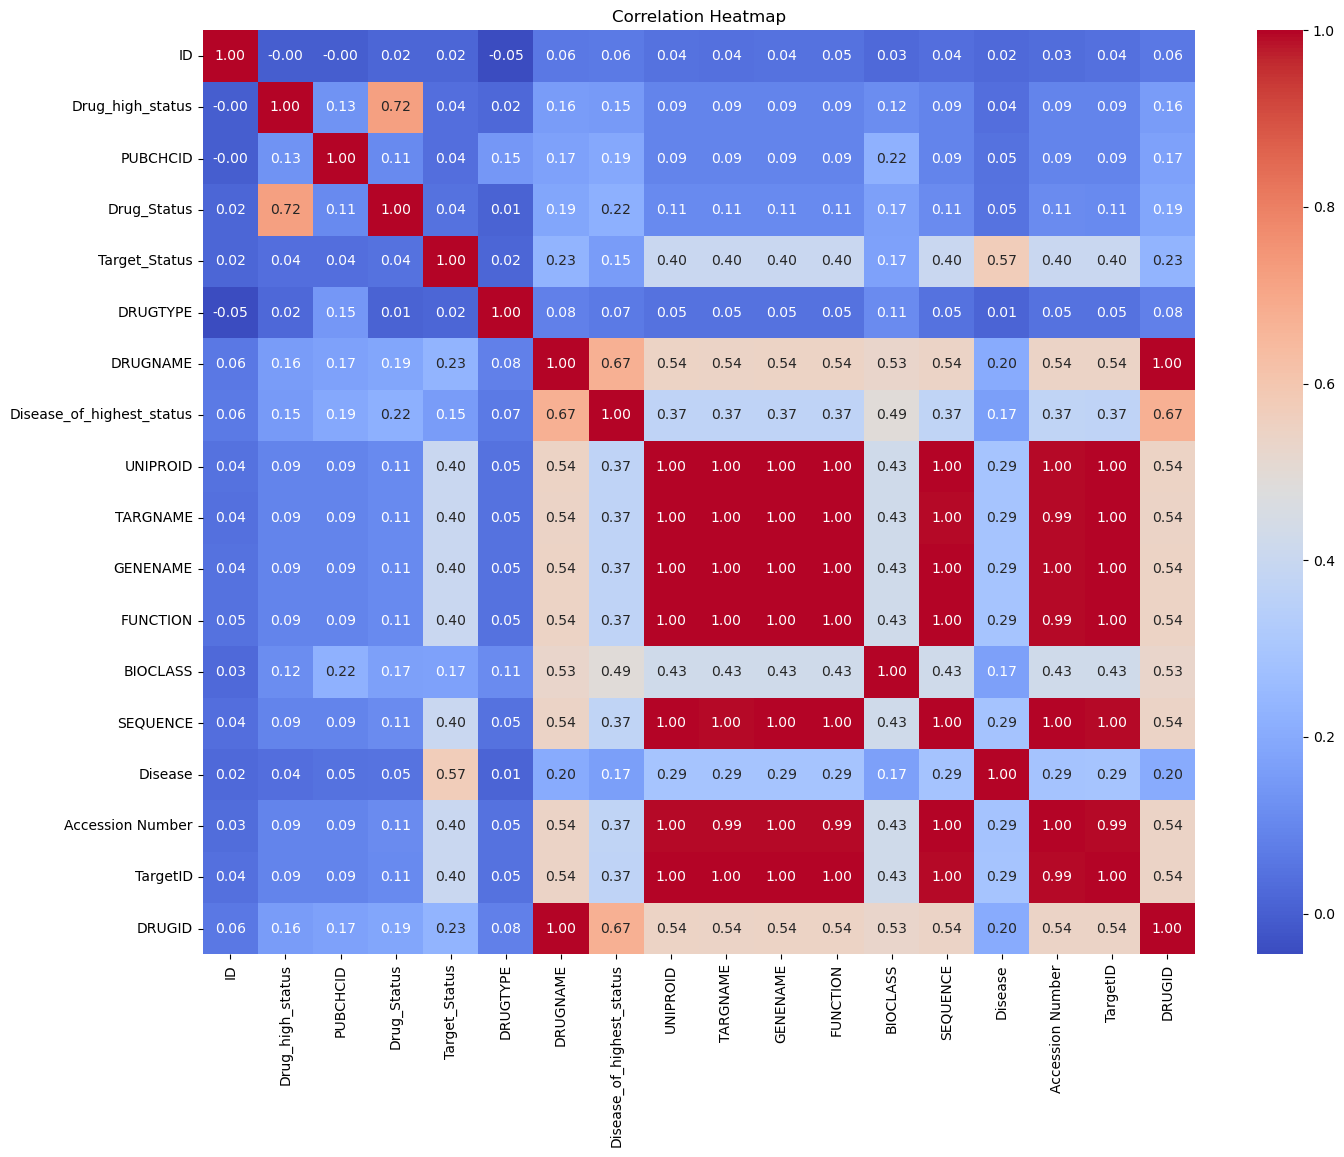

In [9]:
corr = df_train_final[['ID', 'Drug_high_status', 'PUBCHCID', 'Drug_Status',
       'Target_Status', 'DRUGTYPE', 'DRUGNAME', 'Disease_of_highest_status',
       'UNIPROID', 'TARGNAME', 'GENENAME', 'FUNCTION', 'BIOCLASS', 'SEQUENCE',
       'Disease', 'Accession Number', 'TargetID', 'DRUGID']].corr()

plt.figure(figsize=(16, 12))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

In [10]:
X = df_train_final.drop('SYNONYMS', axis=1)
X_with_constant = sm.add_constant(X)
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X_with_constant.values, i) for i in range(1, X_with_constant.shape[1])]

print("VIF:")
print(vif_data)

/Users/dhruvshah/anaconda3/lib/python3.11/site-packages/statsmodels/stats/outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


VIF:
                     Variable           VIF
0                          ID  1.032755e+00
1            Drug_high_status  2.087309e+00
2                    PUBCHCID  1.089493e+00
3                 Drug_Status  2.126676e+00
4               Target_Status  1.635694e+00
5                    DRUGTYPE  1.032619e+00
6                    DRUGNAME           inf
7   Disease_of_highest_status  1.967410e+00
8                    UNIPROID  1.076311e+05
9                    TARGNAME           inf
10                   GENENAME  1.075893e+05
11                   FUNCTION  6.268070e+02
12                   BIOCLASS  1.562181e+00
13                   SEQUENCE  4.132576e+02
14                    Disease  1.506788e+00
15           Accession Number  2.887100e+02
16                   TargetID           inf
17                     DRUGID           inf


In [11]:
X = df_train_final.drop(['Target_Status', 'SYNONYMS', 'DRUGNAME'], axis=1)
y = df_train_final['Target_Status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = X_train
X_test_scaled = X_test

# Create and train the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = rf_model.predict(X_test_scaled)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')  # 'weighted' for multi-class problems

print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Feature importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance.head(20))
plt.title('Top 20 Feature Importance in Random Forest Model')
plt.tight_layout()
plt.show()

Accuracy: 0.9174
F1 Score: 0.9171

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        13
           1       0.93      0.95      0.94      6168
           2       1.00      0.66      0.79        32
           3       1.00      1.00      1.00         1
           4       0.92      0.86      0.89        70
           5       0.95      0.90      0.92       475
           6       0.69      0.75      0.72        24
           7       0.94      0.91      0.93      1177
           8       0.90      0.82      0.86        11
          10       1.00      0.33      0.50         3
          11       0.96      0.90      0.93       506
          12       1.00      0.75      0.86         4
          13       1.00      0.95      0.97        20
          14       0.94      1.00      0.97        16
          15       0.91      0.90      0.91      1866
          17       0.88      0.89      0.89       628
          18       1.00

In [13]:
A = df_test_final.drop(['DRUGNAME', 'SYNONYMS'], axis=1)
predictions_encoded = rf_model.predict(A)

# Decode the predictions
predictions_decoded = le.inverse_transform(predictions_encoded)

# Create the submission DataFrame
submission_df = pd.DataFrame({
    "Id": df_test_final['ID'],
    "Predictions": predictions_decoded
})

# Save to CSV
submission_file_path = "rdf_predictions_decoded.csv"
submission_df.to_csv(submission_file_path, index=False)

print(f"Decoded predictions saved to {submission_file_path}")

# If you want to verify the decoding
print("Sample of decoded predictions:")
print(submission_df.head())

Decoded predictions saved to rdf_predictions_decoded.csv
Sample of decoded predictions:
       Id Predictions
0    1076    Approved
1  190816     Phase 2
2  180551     Phase 3
3   51630    Approved
4   50566     Phase 2


In [14]:
encoding_map = {
    0: "Application submitted",
    1: "Approved",
    2: "Approved (orphan drug)",
    3: "BLA submitted",
    4: "Clinical trial",
    5: "Discontinued in Phase 1",
    6: "Discontinued in Phase 1/2",
    7: "Discontinued in Phase 2",
    8: "Discontinued in Phase 2/3",
    9: "Discontinued in Phase 2a",
    10: "Discontinued in Phase 2b",
    11: "Discontinued in Phase 3",
    12: "Discontinued in Phase 4",
    13: "Discontinued in Preregistration",
    14: "IND submitted",
    15: "Investigative",
    16: "NDA filed",
    17: "Patented",
    18: "Phase 0",
    19: "Phase 1",
    20: "Phase 1 Trial",
    21: "Phase 1/2",
    22: "Phase 1/2a",
    23: "Phase 1b",
    24: "Phase 1b/2a",
    25: "Phase 2",
    26: "Phase 2 Trial",
    27: "Phase 2/3",
    28: "Phase 2a",
    29: "Phase 2b",
    30: "Phase 3",
    31: "Phase 4",
    32: "Preclinical",
    33: "Preregistration",
    34: "Registered",
    35: "Terminated",
    36: "Withdrawn from market",
    37: "approved"
}

# Function to decode predictions
def decode_predictions(encoded_predictions):
    return [encoding_map.get(pred, f"Unknown_{pred}") for pred in encoded_predictions]

# Make predictions
A = df_test_final.drop(['DRUGNAME', 'SYNONYMS'], axis=1)
predictions_encoded = rf_model.predict(A)

# Decode the predictions
predictions_decoded = decode_predictions(predictions_encoded)

# Create the submission DataFrame
submission_df = pd.DataFrame({
    "Id": df_test_final['ID'],
    "Predictions": predictions_decoded
})

# Save to CSV
submission_file_path = "rdf_predictions_decoded.csv"
submission_df.to_csv(submission_file_path, index=False)

print(f"Decoded predictions saved to {submission_file_path}")

# Print a sample of the decoded predictions
print("\nSample of decoded predictions:")
sample_size = min(20, len(predictions_encoded))
sample_indices = np.random.choice(len(predictions_encoded), sample_size, replace=False)
for idx in sample_indices:
    encoded = predictions_encoded[idx]
    decoded = predictions_decoded[idx]
    print(f"Encoded: {encoded}, Decoded: {decoded}")

# Print unique values in the decoded predictions
print("\nUnique decoded predictions:")
print(pd.Series(predictions_decoded).unique())

Decoded predictions saved to rdf_predictions_decoded.csv

Sample of decoded predictions:
Encoded: 25, Decoded: Phase 2
Encoded: 1, Decoded: Approved
Encoded: 27, Decoded: Phase 2/3
Encoded: 35, Decoded: Terminated
Encoded: 25, Decoded: Phase 2
Encoded: 1, Decoded: Approved
Encoded: 19, Decoded: Phase 1
Encoded: 36, Decoded: Withdrawn from market
Encoded: 25, Decoded: Phase 2
Encoded: 1, Decoded: Approved
Encoded: 30, Decoded: Phase 3
Encoded: 25, Decoded: Phase 2
Encoded: 30, Decoded: Phase 3
Encoded: 1, Decoded: Approved
Encoded: 30, Decoded: Phase 3
Encoded: 1, Decoded: Approved
Encoded: 27, Decoded: Phase 2/3
Encoded: 15, Decoded: Investigative
Encoded: 7, Decoded: Discontinued in Phase 2
Encoded: 11, Decoded: Discontinued in Phase 3

Unique decoded predictions:
['Approved' 'Phase 2' 'Phase 3' 'Investigative' 'Phase 1/2' 'Patented'
 'Phase 1' 'Terminated' 'Withdrawn from market' 'Discontinued in Phase 3'
 'Discontinued in Phase 2' 'Phase 2/3' 'Preclinical'
 'Discontinued in Phase 1'